<a href="https://colab.research.google.com/github/armandordorica/APS1070_Anomaly_Detection/blob/master/APS1070_Project_2_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2, APS1070 Summer 2020
**Anomaly Detection Algorithm using Gaussian Mixture Model [20 Marks]**

**Deadline: June 18, 23:00 - 20 points**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Armando Ordorica
*   Student Number: 100 599 2164

##Part 1: Getting started [6 Marks]

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? 284807
* What features in the dataset are present aside from the 28 main features?  4: time, amount, class, rows. 
* Which column contains the targets? To what do the values correspond? Column `class` contains the target, which is whether it was fraud (1) or not (0). 492 Fraud and 284315 non Fraud. 

In [3]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=1e266206f181aad164baad15da157dc1d77db3dafc70d1d06b54ed138196345f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import wget
import matplotlib.pyplot as plt

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [5]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')
df['rows']= np.arange(0,df['V23'].values.shape[0],1)

In [7]:
df.shape

(284807, 32)

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,rows
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,3
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4


In [9]:
df['Class'].unique()

array([0, 1])

In [10]:
df.groupby('Class').count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,rows
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492


In [11]:
fraud_pct = 492 /(492+284315)
fraud_pct 

0.001727485630620034

In [12]:
1- fraud_pct 

0.9982725143693799

It's important when looking at a new dataset to figure out how many examples we have for each class.

* What is the percentage of entries in the dataset for each class? 492 Fraud and 284315 non Fraud - 0.17 % for Fraud and 99.83% for non-Fraud 
* Is this data considered balanced or unbalanced? Why is this the case? Unbalanced because the target vs non target distribution is very different. The ratio of 0s to 1s is ~99:1, whereas a perfectly balanced dataset would be 1:1 between both target classes.  
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1?  
For Project 1, the dataset was relatively balanced  212 - Malignant, 357 - Benign, ~4:6 ratio.

If the training set were to be imbalanced, and if the uniform distribution assumption were to still hold, the probability that the k nearest neighbors of any random query point will belong to the class with more examples becomes higher. So, the closest neighbor of the query point may still belong to the class with less examples, but if rest (k-1) points belong to the other class (because of its higher density in the space), the point will get misclassified.  In that case, a 1-nearest neighbor approach might yield better results for you depending on how your data looks like. 

There are methods to improve performance of KNN on unbalanced datasets such as downsampling. This consists of ignoring samples in the dataset that belong to the class with the highest density, such that both classes have a relatively equal number of samples, ideally a 1:1 ratio. 

 


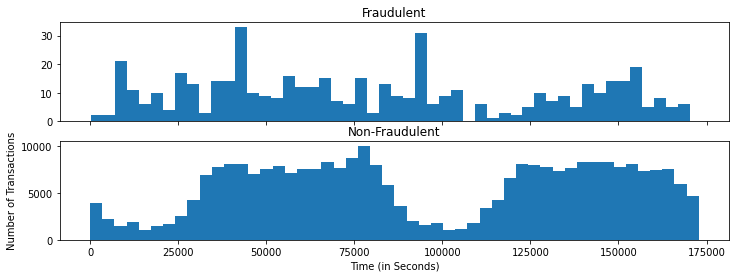

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Time[df.Class == 1], bins = 50)
ax1.set_title("Fraudulent")
ax2.hist(df.Time[df.Class == 0], bins = 50)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

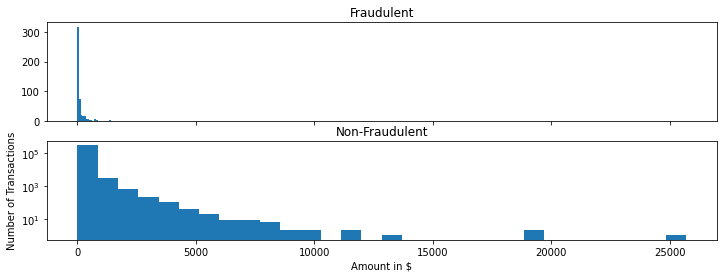

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Amount[df.Class == 1], bins = 30)
ax1.set_title("Fraudulent")
ax2.hist(df.Amount[df.Class == 0], bins = 30)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Amount in $')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

df["Normalized_Amount"] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#Drop time & amount variable
df = df.drop(['Time', 'Amount'], axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,rows,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,3,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4,-0.073403


In [16]:
Class = [len(df.loc[df.Class == 1]), len(df.loc[df.Class == 0])]
pd.Series(Class, index = ['Fraudulent', 'Non-fraudulent'], name = 'target')

Fraudulent           492
Non-fraudulent    284315
Name: target, dtype: int64

In [17]:
#Percentage of minority(fraudulent) class
print('% of Fraudulent Class = {:.3f}%'.format(len(df[df.Class == 1])*100 / len(df)))

% of Fraudulent Class = 0.173%


In [0]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["RF", "XGB", "LGB"]
    RFC = RandomForestClassifier(random_state = 0)
    XGBC = XGBClassifier(random_state = 0)
    LGBC = LGBMClassifier(random_state = 0)

    for clf,i in zip([RFC, XGBC, LGBC], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve", fontsize = 18)
        ax2.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

Next, split the dataset into a training and testing set. Use a test size of one third, and set the random state to 1.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in this lab we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V11? Make sure to only use your training set for this calculation. 
  * **`std_dev=1.0224332645928247` and `mean=0.00044933624793198267`**

Use the code below to set up a Gaussian object for V11.

In [0]:
y = df['Class']

In [0]:
X = df.loc[:, df.columns != 'Class']


In [0]:
### Split the data  ###
# X_train, X_test, y_train, y_test = 0, 0, 0, 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [22]:
arr = np.array(X_train['V11'])
arr

array([ 0.86523513, -1.6408142 ,  0.79507923, ..., -0.39557416,
        1.05104284, -1.12257999])

In [23]:
std_dev = np.std(arr)
std_dev

1.0224332645928247

In [24]:
mean = np.mean(arr)
mean


0.00044933624793198267

In [0]:
from scipy import stats

norm = stats.norm(
    loc = mean,
    scale = std_dev

)

In [29]:
stats.norm(0, 1).cdf(0)

0.5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


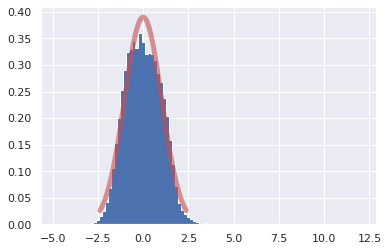

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.gridspec as gridspec

var_name = 'V11'

fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train[var_name].values, density=True, histtype='stepfilled', bins=100);
plt.show()



We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

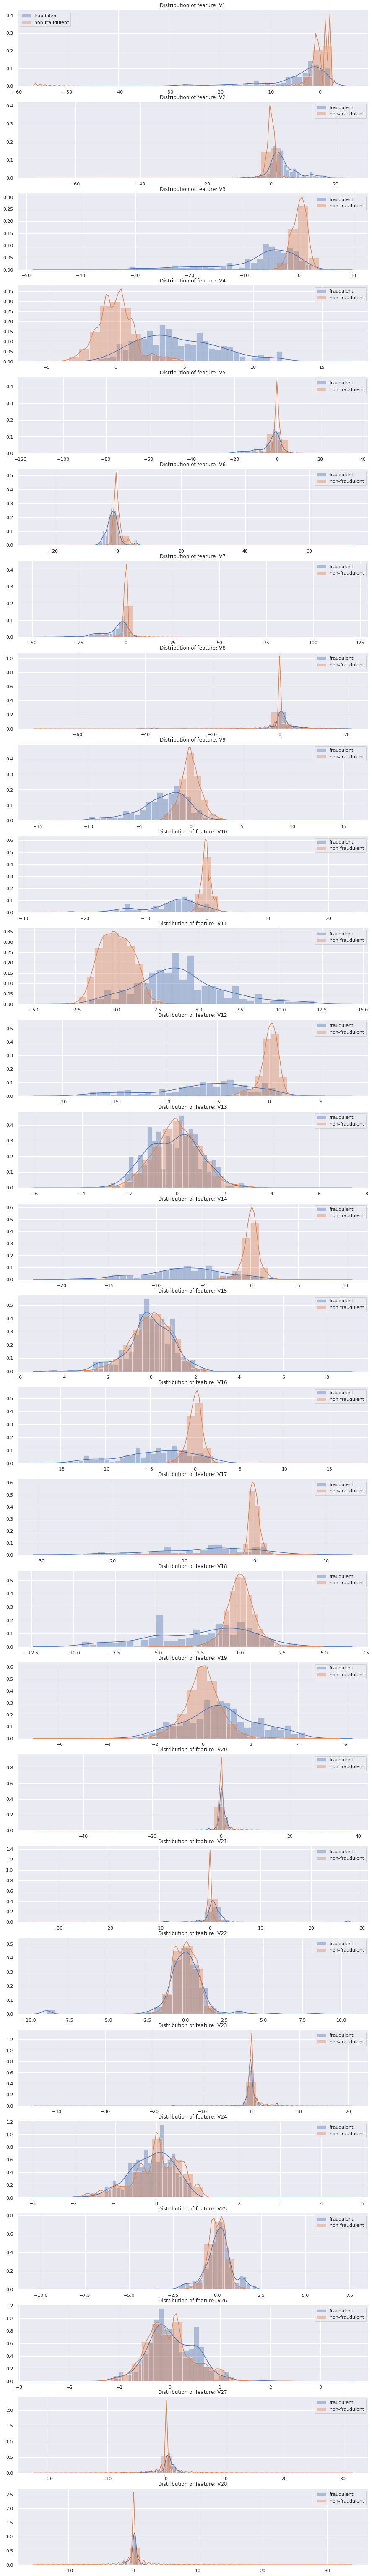

In [0]:
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

**Q.** Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[2 Marks]**

**The more in-line the mean of the distribution between the two classes are, the less informative the variable is and the less useful it is to help us detect anomalies. For variables where the statistics (mean and variance) for fraudulent vs non-fraudulent are far off, such as for V18, we could tell that that specific variable is giving some information about the anomalies. Fraud attacks usually have a common characteristic and don't follow the same distribution as the rest of the transactions. For example, they could be all associated to a specific country code or a specific merchant category code.**

## Part 2: Single Variable Gaussian Distribution: [7 Marks]
We'll start by making a prediction using **a single feature of our dataset at a time**. Let's explore the following scenarios:

1.   **One Gaussian:** First, we will fit a single gaussian distribution.

  *   Plot a ROC curve for each feature, fitting non-fraudulent transactions.
  *   Find the best feature to distinguish fraudulent transactions from non-fraudulent transactions based on AUC (Area under the ROC Curve)
  *  To make a prediction, we compute the probability that each transaction in the training set belongs to that distribution. If the probability is lower than a threshold, we consider that transaction a fraud. Find an optimal threshold that maximizes the F1 Score in the training set. Report peformance on the test set as well.

  


2.   **Two Gaussians:** In this case, we will fit a Gaussian to each class in the selected feature above — one gaussian to the feature of non-fraudulent transactions and one gaussian for fraudulent transactions. To make predictions, we use the probability of a transaction belonging to the fraudulent Gaussian distribution and non-fraudulent distribution. 

  * Build a classifier using this two-gaussian approach on the training set, and once complete, test performance on the test set.

Summarize your findings.


In [1]:
mean = np.mean(X['V1'])

NameError: ignored

In [2]:
std_dev = np.std(X['V1'])

NameError: ignored

In [0]:
sigma2 = std_dev**2

In [0]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def fit_gaussian(data): 
  # Generate some data for this demonstration.
  # data = X['V1']

  # Fit a normal distribution to the data:
  mu, std = norm.fit(data)

  # Plot the histogram.
  plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.plot(x, p, 'k', linewidth=2)
  title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
  plt.title(title)

  plt.show()

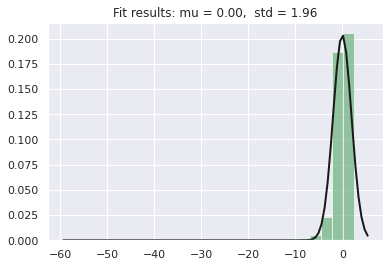

In [73]:
fit_gaussian(X['V1'])

In [77]:
mean

3.919560084655042e-15

In [78]:
std_dev

1.958692365217412

In [82]:
sigma2


3.8364757815609796

In [0]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

In [0]:
 X = X_train['V1'].min()

In [85]:
X

-56.407509631329

In [86]:
multivariateGaussian(X, mean, sigma2)

TypeError: ignored

In [0]:
input_X_train = X_train
input_X_test = X_test

In [0]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

ROC AUC SCORE:0.965296656752235
Naive Bayes: AUROC = 0.965


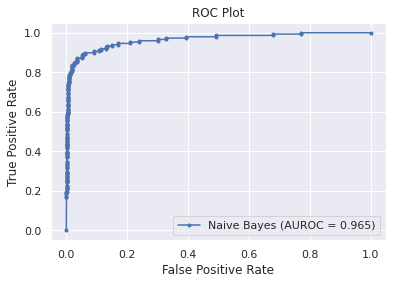

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np


nb = GaussianNB()
nb.fit(np.array(input_X_train), y_train)


r_probs = [0 for _ in range(len(y_test))]
nb_probs = nb.predict_proba(input_X_test)

nb_probs = np.array(nb_probs)
y_pred = nb_probs[:,1]

print("ROC AUC SCORE:{}".format(roc_auc_score(y_test, y_pred)))

nb_auc = roc_auc_score(y_test, y_pred)
print('Naive Bayes: AUROC = %.3f' % (nb_auc))

nb_fpr, nb_tpr, _ = roc_curve(y_test, y_pred)

plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()


In [0]:
input_X_train = X_train['V1']

In [0]:
input_X_test = X_test['V1']

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np


nb = GaussianNB()
nb.fit(np.array(input_X_train), y_train)


r_probs = [0 for _ in range(len(y_test))]
nb_probs = nb.predict_proba(input_X_test)

nb_probs = np.array(nb_probs)
y_pred = nb_probs[:,1]

print("ROC AUC SCORE:{}".format(roc_auc_score(y_test, y_pred)))

nb_auc = roc_auc_score(y_test, y_pred)
print('Naive Bayes: AUROC = %.3f' % (nb_auc))

nb_fpr, nb_tpr, _ = roc_curve(y_test, y_pred)

plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()


ValueError: ignored

In [0]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance of X
    var = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,var
mu, sigma2 = estimateGaussian(X)

In [0]:
estimateGaussian(X['V1'])

(1.165979954793388e-15, 3.8364757815610058)

In [0]:
# One Gaussian 
### HERE ###

In [0]:
# Two Gaussians
### HERE ###

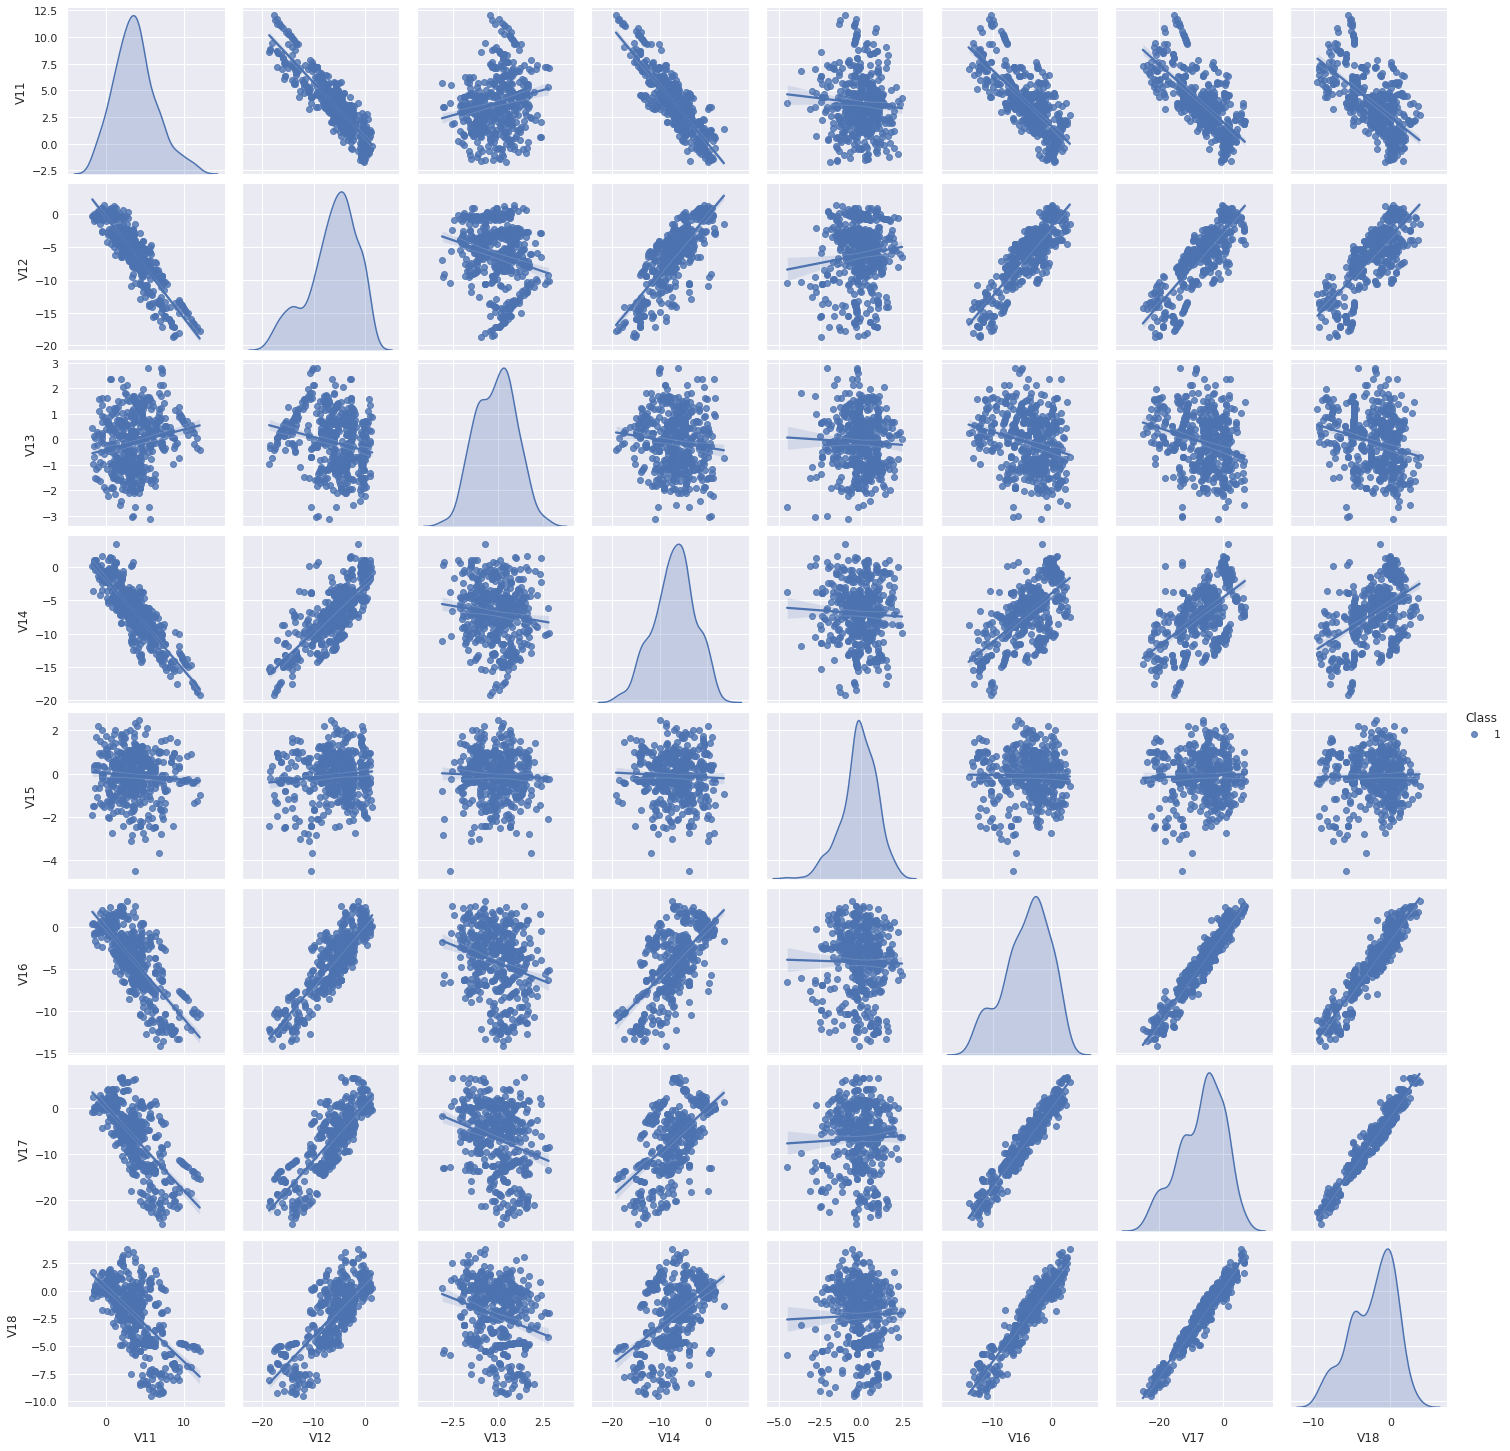

In [109]:
sns.pairplot(df[df.Class==1], vars=['V11','V12','V13','V14', 'V15', 'V16', 'V17', 'V18'], kind='reg', hue='Class')

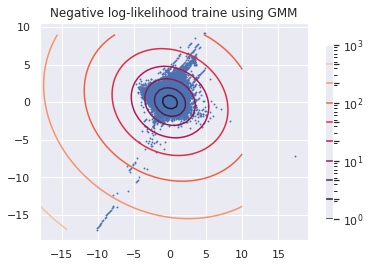

In [110]:
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn import mixture

df_0=df[df.Class==0]    #Dataset with non-fraudulent only
df_1=df[df.Class==1]    #Dataset with fraudulent only
df_0=df_0[['V16', 'V17','Class']]    #Select two most correlated features for now
df_1=df_1[['V16', 'V17', 'Class']]

#Split non-fraudulent data in 90% for training GMM and 10% for cross-validation and testing
X_train, X_test, y_train, y_test = train_test_split(df_0.drop(['Class'],axis=1), df_0['Class'] , test_size=0.1, random_state=0)
#Split the fraudulent data in 50% for cross-validation and 50% for testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1.drop(['Class'],axis=1), df_1['Class'] , test_size=0.5, random_state=0)

# Fit a Gaussian Mixture Model with the two components 'V14' and 'V17'
clf = mixture.GaussianMixture()
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-18, 10)
y = np.linspace(-17, 9.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train['V16'].values,X_train['V17'].values, 0.8)
plt.title('Negative log-likelihood traine using GMM')
plt.axis('tight')
plt.show()


Text(0.5, 1.0, 'Predicted probabilities for test dataset')

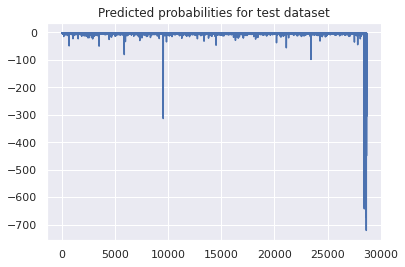

In [111]:
######### Cross-validation step to select best threshold T still to be done ####
#  KFold=...
#################################################################################
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
y_test_proba = clf.score_samples(np.vstack([X_test, X_test_1]))
plt.plot(y_test_proba)
plt.title('Predicted probabilities for test dataset')

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.94      0.51      0.66       246

    accuracy                           1.00     28678
   macro avg       0.97      0.76      0.83     28678
weighted avg       1.00      1.00      0.99     28678

Test AUCPR = 0.48580070091743094


Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.49')

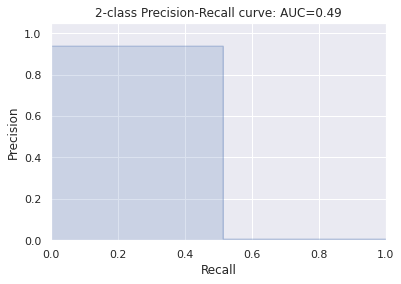

In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
T=-40
y_test_proba[y_test_proba>=T]=0
y_test_proba[y_test_proba<T]=1

y_test_orig=np.hstack([y_test, y_test_1])
print('Classification report')
print(classification_report(y_test_orig, y_test_proba))
print('Test AUCPR = ' + str(average_precision_score(y_test_orig, y_test_proba)))



precision, recall, _ = precision_recall_curve(y_test_orig, y_test_proba)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test_orig, y_test_proba)))

## Part 3: Multivariate and Mixture of Gaussian Distribution [7 Marks]
We want to build an outlier detection model that boosts our F1 score compared to the last part. To design your model, you can benefit from:

*   Any number of features you want (multivariate).
*   You can fit your Gaussians only on non-fraudulent transactions or to both classes.
*   To fit your model, you can take advantage of the Gaussian mixture model where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (take a look at the hint below).

It is up to you how to design your model. Try at least 5 different models and report the F1 score for each one. If your model requires a threshold to classify transactions, draw a ROC curve for each model, and compare them with part 2.1. Try to maximize your F1 score. What kind of model works better? How many features? Which features? How many Gaussians? How many components? Summarize your findings with tables and plots. 


**HINT!**

Does it make sense to have more than two Gaussians (or a mixture with more than 2 components) in this kind of (binary) task?

 The answer is YES, and it depends on the distribution of data. Remember the tutorial, where we had 5 clusters and fit a mixture of 5 Gaussians to detect outliers. Consider the transaction is valid if it is close to each one of those five clusters, and it is not valid if it is not close to them! For example (figure below), assume we have a high volume of legitimate transactions in the morning until lunchtime (9 AM to 12 PM). We have fewer transactions during lunchtime. Then we have another pick between (1 PM to 4 PM). In this example, it is reasonable to have two valid clusters (compenents), one for the morning and another for the afternoon transactions.
 ![Example:](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/AMoW2.png)


In [0]:
class Gaussian:
    def __init__(self, mu, sigma):
        # mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    def pdf(self, datum):
        "probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (np.sqrt(2 * np.pi) * abs(self.sigma))) * np.exp(-u * u / 2)
        return y

    def log_pdf(self, datum):
        "log probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = np.log((1 / (np.sqrt(2 * np.pi) * abs(self.sigma)))) + (-u * u / 2)
        return y

    def log_pdf_np(self, X):
        Y = (X - self.mu) / abs(self.sigma)
        Y = np.log((1 / (np.sqrt(2 * np.pi) * abs(self.sigma)))) + (-Y ** 2 / 2)
        return Y

In [0]:
class GaussianMixture:
    """
        using numpy package for computation
        optimize the computational speed of the em algorithm
    """
    def __init__(self, n_components):
        # list of gaussian components
        self.g = None

        # weights of the gaussian components
        self.mix = None

        # the number of mixture components.
        self.n_components = n_components

        # the convergence threshold.
        # em iterations will stop when the lower bound average gain is below this threshold.
        self.tol = 0.001

        # number of step used by the best fit of EM to reach the convergence.
        self.n_iter_ = None

        # the method used to initialize the weights, the means and the precisions.
        self.init_params = 'kmeans'

    def _initialize_parameters(self, X, random_state=42):
        """Initialize the model parameters.

        Parameters
        ----------
        X : array-like, shape  (n_samples, n_features)

        random_state : RandomState
            A random number generator instance.
        """
        n_samples, _ = X.shape

        if self.init_params == 'kmeans':
            resp = np.zeros((n_samples, self.n_components))
            label = KMeans(n_clusters=self.n_components, n_init=1,
                                random_state=random_state).fit(X).labels_
            resp[np.arange(n_samples), label] = 1
        else:
            raise ValueError("Unimplemented initialization method '%s'"
                             % self.init_params)

        self.m_step(X, resp)

    def init_model(self, X):
        mu_min = min(X)
        mu_max = max(X)
        sigma_min = 1
        sigma_max = 1

        g = []
        mix = []
        for i in range(self.n_components):
            g.append(Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max)))
            mix.append(1 / self.n_components)

        self.g = g
        self.mix = mix

        return self

    def e_step(self, X):
        """e step.

        Parameters
        ----------
        X : array-like, shape (n_samples,)

        Returns
        -------
        log_prob_norm : float
            Mean of the logarithms of the probabilities of each sample in X

        log_responsibility : array, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        assert X is not None and len(X) > 0, 'X is none or empty'
        assert self.g is not None and len(self.g) > 0, 'g is none or empty'
        assert self.mix is not None and len(self.mix) > 0, 'mix is none or empty'
        assert len(self.g) == len(self.mix), 'length of g and mix is not equal'

        log_prob_norm, log_resp = self.estimate_log_prob_resp(X)
        return np.mean(log_prob_norm), log_resp

    def estimate_log_prob_resp(self, X):
        """Estimate log probabilities and responsibilities for each sample.

        Refer to function "_estimate_log_prob_resp()" in sklearn\mixture\base.py

        Compute the log probabilities, weighted log probabilities per
        component and responsibilities for each sample in X with respect to
        the current state of the model.

        Parameters
        ----------
        X : array-like, shape (n_samples,)

        Returns
        -------
        log_prob_norm : array, shape (n_samples,)
            log p(X)

        log_responsibilities : array, shape (n_samples, n_components)
            logarithm of the responsibilities
        """

        # weighted_log_prob : array, shape (n_samples, n_components)
        # weighted_log_prob = self.estimate_weighted_log_prob(X)
        weighted_log_prob = self.estimate_weighted_log_prob_np(X)

        # log_prob_norm: array, shape (n_samples,)
        #       i.e., log p(X)
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        assert len(log_prob_norm) == len(X), 'length of log_prob_norm error'

        with np.errstate(under='ignore'):
            # ignore underflow
            # log_resp : array, shape (n_samples, n_components)
            #       logarithm of the responsibilities
            log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]

        return log_prob_norm, log_resp

    def estimate_weighted_log_prob(self, X):
        # refer to function "_estimate_weighted_log_prob()" in sklearn\mixture\base.py
        # estimate the weighted log-probabilities, log P(X | Z) + log weights.
        # weighted_log_prob : array, shape (n_samples, n_components)
        weighted_log_prob = []
        for i in range(len(self.g)):
            a = [self.g[i].log_pdf(x) + np.log(self.mix[i]) for x in X]
            # here we assume X is 1D array
            assert len(a) == len(X), 'length of array a error'
            weighted_log_prob.append(a)

        weighted_log_prob = np.array(weighted_log_prob)
        return weighted_log_prob.T

    def estimate_weighted_log_prob_np(self, X):
        # refer to function "_estimate_weighted_log_prob()" in sklearn\mixture\base.py
        # estimate the weighted log-probabilities, log P(X | Z) + log weights.
        # weighted_log_prob : array, shape (n_samples, n_components)
        X = np.array(X)
        X = X.flatten()
        weighted_log_prob = []
        for i in range(len(self.g)):
            a = self.g[i].log_pdf_np(X)
            # here we assume X is 1D array
            assert len(a) == len(X), 'length of array a error'
            weighted_log_prob.append(a)

        weighted_log_prob = np.array(weighted_log_prob)
        return weighted_log_prob.T

    def m_step(self, X, resp):
        """M step.

        Parameters
        ----------
        X : array-like, shape (n_samples,)

        log_resp : array-like, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """

        # nk : array-like, shape (n_components,)
        #   The numbers of data samples in the current components.
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps

        resp = resp.T

        # compute new means
        for i in range(len(self.g)):
            self.g[i].mu = np.dot(resp[i], np.array(X)) / nk[i]

        # compute new sigmas
        for i in range(len(self.g)):
            self.g[i].sigma = np.sqrt(np.dot(resp[i], (np.array(X) - self.g[i].mu) ** 2) / nk[i])

        # compute new mix
        for i in range(len(self.g)):
            self.mix[i] = nk[i] / len(X)

    def pdf(self, x):
        v = 0
        for i in range(len(self.g)):
            v += self.g[i].pdf(x) * self.mix[i]
        return v

    def fit(self, X, max_iter):
        "perform n iterations, then compute log-likelihood"
        self._initialize_parameters(X)

        lower_bound = None

        for i in range(max_iter):
            self.n_iter_ = i
            # print("iter: " + str(i))
            prev_lower_bound = lower_bound

            # if verbose:
            #     print('iteration: ' + str(i))

            log_prob_norm, log_resp = self.e_step(X)
            self.m_step(X, np.exp(log_resp))

            lower_bound = log_prob_norm

            if prev_lower_bound is not None:
                change = lower_bound - prev_lower_bound
                if abs(change) < self.tol:
                    break

    def score_samples(self, X):
        """Compute the weighted log probabilities for each sample.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log probabilities of each data point in X.
        """
        # weighted_log_prob : array, shape (n_samples, n_components)
        # weighted_log_prob = self.estimate_weighted_log_prob(X)
        weighted_log_prob = self.estimate_weighted_log_prob_np(X)

        # log_prob_norm: array, shape (n_samples,)
        #       i.e., log p(X)
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        assert len(log_prob_norm) == len(X), 'length of log_prob_norm error'

        return log_prob_norm


In [0]:
class GMM:
    def __init__(self):
        self._gmm_list = None
        self._log_prior = None

    def fit(self, X, y, n_components, max_iter=100):
        self._log_prior = np.log(np.bincount(y) / len(y))

        # shape of log_pdf
        shape = (len(self._log_prior), X.shape[1])

        self._gmm_list = np.empty(shape, dtype=object)
        for i in range(shape[0]):
            for j in range(shape[1]):
                print('fit model ({0},{1})'.format(i, j))
                model = GaussianMixture(n_components)
                a = X[y == i, j:j + 1]
                model.init_model(a)
                model.fit(a, max_iter)
                self._gmm_list[i, j] = model
                print('n_iter_: {0}'.format(model.n_iter_))

    def predict_proba(self, X):
        assert self._gmm_list is not None, 'gmm list is none'
        assert self._log_prior is not None, 'log prior is none'

        # shape of log_likelihood before summing
        shape = (len(self._log_prior), X.shape[1], X.shape[0])

        ll = [[self._gmm_list[i][j].score_samples(X[:, j:j + 1])
                    for j in range(shape[1])]
                    for i in range(shape[0])]

        log_likelihood = np.sum(ll, axis=1).T

        log_joint = self._log_prior + log_likelihood

        predicts = np.exp(log_joint - logsumexp(log_joint, axis=1, keepdims=True))
        return predicts

In [94]:
from random import uniform
from sklearn.cluster import KMeans
from scipy.special import logsumexp


n_components = 10
g = GMM()
g.fit(np.array(X_train), np.array(y_train), n_components)

fit model (0,0)
n_iter_: 19
fit model (0,1)
n_iter_: 9
fit model (0,2)
n_iter_: 14
fit model (0,3)
n_iter_: 14
fit model (0,4)
n_iter_: 8
fit model (0,5)
n_iter_: 11
fit model (0,6)
n_iter_: 8
fit model (0,7)
n_iter_: 14
fit model (0,8)
n_iter_: 18
fit model (0,9)
n_iter_: 13
fit model (0,10)
n_iter_: 11
fit model (0,11)
n_iter_: 18
fit model (0,12)
n_iter_: 16
fit model (0,13)
n_iter_: 13
fit model (0,14)
n_iter_: 21
fit model (0,15)
n_iter_: 14
fit model (0,16)
n_iter_: 13
fit model (0,17)
n_iter_: 15
fit model (0,18)
n_iter_: 15
fit model (0,19)
n_iter_: 10
fit model (0,20)
n_iter_: 11
fit model (0,21)
n_iter_: 12
fit model (0,22)
n_iter_: 9
fit model (0,23)
n_iter_: 27
fit model (0,24)
n_iter_: 13
fit model (0,25)
n_iter_: 17
fit model (0,26)
n_iter_: 14
fit model (0,27)
n_iter_: 18
fit model (0,28)
n_iter_: 5
fit model (0,29)
n_iter_: 54
fit model (1,0)
n_iter_: 55
fit model (1,1)
n_iter_: 25
fit model (1,2)
n_iter_: 8
fit model (1,3)
n_iter_: 38
fit model (1,4)
n_iter_: 14
fit mo

In [95]:
predicts = g.predict_proba(np.array(X_test))
auc = roc_auc_score(y_test, predicts[:, 1])
    
print(auc)

0.9586314527210638
